Problem Statement
About Company
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

Problem
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('training_data.txt')
df.head(10) # print first 10 rows of dataset
df.describe() # Get summary of numerical variables

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Inferences you can draw by looking at the output of the describe() function:
    1. LoanAmount has (614 - 592) 22 missing values
    2. Loan_Amount_Term has (614 - 600) 14 missing values
    3. Credit_History has (614 - 564) 50 missing values
    4. 84% of applicants have credit history (looking at mean, given that 
       Credit_History is either 1 for those who have credit history or 0 
       otherwise)

In [2]:
# for non-numerical data check to see if frequency distribution makes
# sense (233 + 202 + 179 = 614)
df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

Distribution analysis

Now lets investigate the distribution of various variables. Lets start with numeric variables - ApplicantIncome and LoanAmount

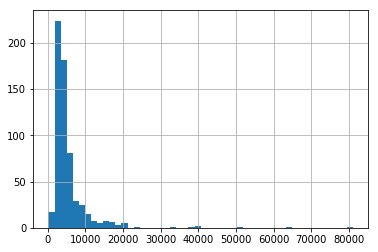

In [3]:
df['ApplicantIncome'].hist(bins=50)

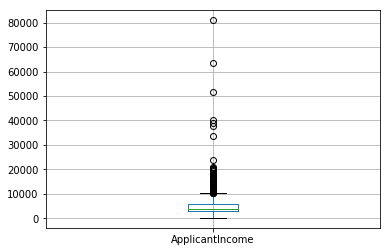

In [4]:
df.boxplot(column='ApplicantIncome')

By plotting both a histogram and a boxplot, we can see there are a lot of outlier values given the diversity of applicant's income in society. Part of this desparity could be driven by education level. Lets segregate them by Education:

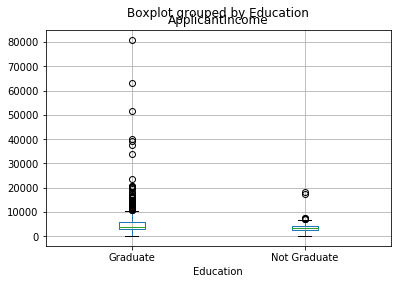

In [5]:
df.boxplot(column='ApplicantIncome',by = 'Education')

We can see that the mean income of graduates and non-graduates is relatively close by looking at the position of the blue boxes on the boxplot. Notice that there are a higher number of graduates with higher incomes compared to the non-graduates. 

Next, lets examine a histogram and boxplot of LoanAmount

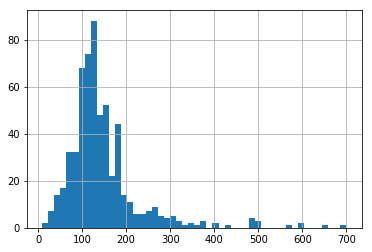

In [6]:
df['LoanAmount'].hist(bins=50)

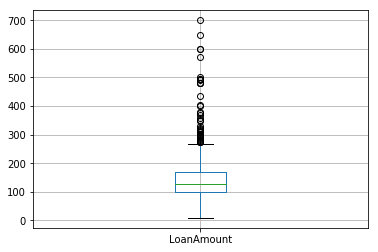

In [7]:
df.boxplot(column='LoanAmount')

Categorical Variable Analysis

Now lets look at the chances of getting a loan based on credit history. Lets create a pivot table where we take the mean of how many people with credit history got approved for a loan vs how many have credit history in general. And lets do the same with those who do not have credit history and still got approved.

In [8]:
temp1 = df['Credit_History'].value_counts(ascending = True)
temp2 = df.pivot_table(values='Loan_Status',index=['Credit_History'],
                      aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
# you are basically determining "of the loans that got approved, what percent had/did not have credit history"
# df[(df['Credit_History'] == 0.0) & (df['Loan_Status'] == 'Y')] (7 rows returned)
# df[(df['Credit_History'] == 1.0) & (df['Loan_Status'] == 'Y')] (378 rows returned)
# 
print('Frequency Table for Credit History: ')
print(temp1)

print('\nProbability of getting loan for each Credit History class: ')
print(temp2)

Frequency Table for Credit History: 
0.0     89
1.0    475
Name: Credit_History, dtype: int64

Probability of getting loan for each Credit History class: 
                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


Now lets make a bar graph demonstrating the resulting pivot table.

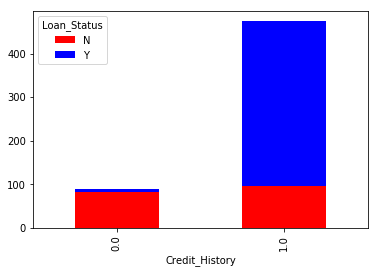

In [9]:
temp3 = pd.crosstab(df['Credit_History'], df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

Data Wrangling

Now that we have explored the data it is time to clean up some loose ends. Here is what we know:
    1. There are missing values in some variables. We should estimate those values wisely depending on the amount of missing values and the expected importance of variables. 
    2. While looking at the distributions, we saw that ApplicantIncome and Loanamount seemed to contain extreme values at either end. Though they might make intutive sense, but should be treated appropriately. 
    
Lets now check the data set for missing values!

In [10]:
# this command tells us the number of missing vlaues in each column
df.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Now we need to fill in these missing data values. One way to do this is by filling in each NA with the mean of the column so that the overarching ratio of LoanAmount to LoanApproved reamins the same.

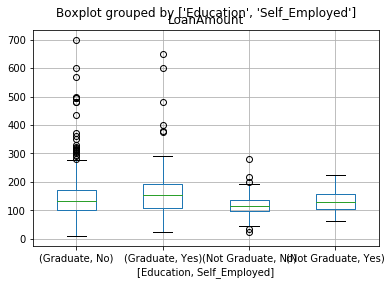

In [11]:
df['LoanAmount'].fillna(df['LoanAmount'].mean(),inplace=True)
df.boxplot(column='LoanAmount',by=['Education','Self_Employed'])

We can see that the median for LoanAmount varies. However, we need to ensure that the Self_Employed and Education variables do not contain missing values. 

In [12]:
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

Since ~86% values are "No", it is safe to impute the missing values as "No" as there is a high probability of success. A better approach would be fit the training data to match values of "Yes" or "No" for Self_Employed and use these predictions to replace the missing values. But for simplicity sake lets just fill in the missing values as "No" for now.

In [13]:
df['Self_Employed'].fillna('No',inplace=True)

In [14]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

Building a Predictive Model

Now that we have filled in all the NA values lets build a predictive model!

In [15]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes 

Loan_ID               object
Gender                 int32
Married                int32
Dependents             int32
Education              int32
Self_Employed          int32
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int32
Loan_Status            int32
dtype: object

In [30]:
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

#Function for making classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
    # Fit the model:
    model.fit(data[predictors],data[outcome])
    
    #Make predictions on training set:
    predictions = model.predict(data[predictors])
    
    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print("Accuracy: %s" % "{0:.3%}".format(accuracy))
    
    #Perform k-fold cross validation with 5 folds
    kf = KFold(n_splits=5)
    kf.get_n_splits(data)
    error = []
    
    for train, test in kf.split(data):
        #Filter training data
        train_predictors = (data[predictors].iloc[train,:])
        
        #The target we're using to train the algorithm
        train_target = data[outcome].iloc[train]
        
        #Training the algorithm using the predictors and target
        model.fit(train_predictors, train_target)
        
        #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], 
                                data[outcome].iloc[test]))
    
    print("Cross-Validation Score: %s" % "{0:.3%}".format(np.mean(error)))
    
    #fit the model again so that it can be refered outside the function
    model.fit(data[predictors],data[outcome])
    
    

We can easily make some intuitve hypothesis to set the ball rolling. The chances of getting a loan will be higher for:
    1. Applicants having a credit history
    2. Applicants with higher applicant and co-applicant income
    3. Applicants with higher education level
    4. Properties in urban areas with high growth perspectives

Let's make our first model with 'Credit_History'.

In [39]:
outcome_var = 'Loan_Status'
model = LogisticRegression(solver='lbfgs')
predictor_var = ['Credit_History']
classification_model(model, df, predictor_var, outcome_var)

Accuracy: 80.945%
Cross-Validation Score: 80.946%


In [40]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed',
                'Property_Area']
classification_model(model,df,predictor_var,outcome_var)

Accuracy: 80.945%
Cross-Validation Score: 80.946%


A decision tree is another method for making a predictive model. It is known to provide higher accuracy than logistic regression models.

In [44]:
model = DecisionTreeClassifier()
predictor_var = ['Credit_History','Gender','Married','Education']
classification_model(model, df, predictor_var, outcome_var)

Accuracy: 80.945%
Cross-Validation Score: 80.946%


In [49]:
#We can try different combination of variables:
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount','ApplicantIncome']
classification_model(model, df,predictor_var,outcome_var)

Accuracy: 100.000%
Cross-Validation Score: 70.526%


We observed that although the accuracy went up on adding variables, the corss-validation error went down. This is the result of model over-fitting the data.

Lets now try figuring out which features are most important to imporve our accuracy.

In [50]:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print (featimp)

Credit_History      0.292201
ApplicantIncome     0.256544
LoanAmount          0.236793
Dependents          0.056182
Loan_Amount_Term    0.049512
Property_Area       0.042847
Education           0.020597
Married             0.015950
Self_Employed       0.015455
Gender              0.013920
dtype: float64


Let's use the top 5 variables for creating a model. Also, lets use a new method called RandomForestClassifier. We will modify the parameters a bit to try and imporve cross-validation score and reduce overfitting. 

In [62]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['ApplicantIncome','LoanAmount','Credit_History','Dependents','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy: 82.410%
Cross-Validation Score: 81.110%


Lessons learned:
    1. Using a more sophisticated model does not guarantee better results (looking at RandomForest vs LogisticRegression results)
    2. Key to successful model fitting is feature engineering. Hainv the creativity and know-how to use your features to better suit the model. 